# Offer amount prediction KC with classification with dynamic buckets

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [71]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.0.


In [72]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [73]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [74]:
query="""
SELECT * FROM ml_prep.gauthier_offer_amount_prediction_dataset_kc WHERE channel_source IS NOT NULL ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


origin flight_num dest departure_date                          request_id  \
0    TSE        983  GUW     2019-06-28  R2zmT8ALQl1vE6nGIC52ooMzcixRnyQNR0   
1    TSE        119  TBS     2019-06-23  QmqxRhzh5azM5Oh7ZhDDFb3PMg5NXnejKm   
2    BKK        932  ALA     2019-06-30  WU0M77ggVC3kn7sfPTdyuKPcHBwZ1c7GyS   

  upgrade_type offer_status              created pax duration  ...  \
0     BUSINESS     TICKETED  2019-06-25 08:19:15   1      150  ...   
1     BUSINESS     TICKETED  2019-06-19 11:49:57   2      215  ...   
2     BUSINESS     TICKETED  2019-06-19 09:32:28   1      425  ...   

  offer_load_count   first_email_sent_time    last_email_sent_time  \
0                4 2019-06-16 05:00:25.130 2019-06-17 05:23:12.392   
1                3 2019-06-16 08:32:16.166 2019-06-19 09:29:03.038   
2                4 2019-06-19 05:45:14.137 2019-06-28 04:03:24.050   

   email_sent_count  first_email_opened_time  last_email_opened_time  \
0                 6      2019-06-18 12:21:52     2019-06-26 07:08:15   
1                 3      2019-06-17 09:01:01     2019-06-19 11:45:44   
2                15      2019-06-19 09:19:17     2019-06-26 10:49:54   

   email_opened_count  first_email_clicked_time  last_email_clicked_time  \
0                  14                      None                     None   
1                   3                      None                     None   
2                  53                      None                     None   

  email_clicked_count  
0                   0  
1                   0  
2                   0  

[3 rows x 37 columns]

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 37 columns):
origin                                 5180 non-null object
flight_num                             5180 non-null object
dest                                   5180 non-null object
departure_date                         5180 non-null object
request_id                             5180 non-null object
upgrade_type                           5180 non-null object
offer_status                           5180 non-null object
created                                5180 non-null object
pax                                    5180 non-null object
duration                               5180 non-null object
point_of_sale                          5180 non-null object
departure_time                         5180 non-null object
offer_amount_usd                       5180 non-null float64
offer_amount_total_usd                 5180 non-null float64
slider_min_usd                         5180 non-nul

In [76]:
bin_labels = ['LOW', 'MEDIUM', 'HIGH']

df['offer_strength_bucket'] =pd.qcut(df['offer_strength_percentage'],  q=[0, .7, .9, 1], labels=bin_labels)

In [77]:
df[['offer_strength_percentage','offer_strength_bucket']][:4]

offer_strength_percentage offer_strength_bucket
0                   0.139439                MEDIUM
1                   0.073529                MEDIUM
2                   0.014634                   LOW
3                   0.000000                   LOW

In [78]:
df.groupby('offer_strength_bucket').size()

offer_strength_bucket
LOW       3627
MEDIUM    1036
HIGH       517
dtype: int64

# Feature Engineering

In [ ]:
#drop non relevant fields
df = df.drop(['request_id',  'pnr', 'offer_row_number','status',
                'offer_expiration_cutoff_local'       ,
                'offer_expiration_cutoff_server' ,     
                'offer_expiration_minutes'       ,     
                'offer_modification_cutoff_hours'   ,  
                'offer_modification_cutoff_local'   ,  
                'offer_modification_cutoff_server'    ,
                'on_hold'                  ,           
              'is_recent_offer','is_orphaned','customer_id','has_errors'  ], axis=1)



In [80]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_time']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_time']).apply(lambda x: x.month)
df['submission_day_of_week']= pd.to_datetime(df['created']).apply(lambda x: x.dayofweek)
df['submission_hour']= pd.to_datetime(df['created']).apply(lambda x: x.hour)
df['submission_month']= pd.to_datetime(df['created']).apply(lambda x: x.month)
df['submission_year']= pd.to_datetime(df['created']).apply(lambda x: x.year)
df['origin_destination'] = df['origin']+ df['dest']
df["days_before_departure"] =(pd.to_datetime(df["departure_time"])-pd.to_datetime(df["created"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_sent"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_sent"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_opened"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_opened"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)



In [81]:
df.head(3)

origin flight_num dest departure_date                          request_id  \
0    TSE        983  GUW     2019-06-28  R2zmT8ALQl1vE6nGIC52ooMzcixRnyQNR0   
1    TSE        119  TBS     2019-06-23  QmqxRhzh5azM5Oh7ZhDDFb3PMg5NXnejKm   
2    BKK        932  ALA     2019-06-30  WU0M77ggVC3kn7sfPTdyuKPcHBwZ1c7GyS   

  upgrade_type offer_status              created pax duration  ...  \
0     BUSINESS     TICKETED  2019-06-25 08:19:15   1      150  ...   
1     BUSINESS     TICKETED  2019-06-19 11:49:57   2      215  ...   
2     BUSINESS     TICKETED  2019-06-19 09:32:28   1      425  ...   

  last_email_opened_days_before_departure days_since_first_email_opened  \
0                                       2                             6   
1                                       3                             2   
2                                       3                             0   

   days_since_last_email_opened  first_email_clicked_days_before_departure  \
0                            -1                                          0   
1                             0                                          0   
2                            -8                                          0   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         0                               0   
1                                         0                               0   
2                                         0                               0   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                   1   
1                              0                                   3   
2                              0                                   8   

   days_between_first_last_email_opened days_between_first_last_email_clicked  
0                                     7                                     0  
1                                     2                                     0  
2                                     7                                     0  

[3 rows x 64 columns]

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 64 columns):
origin                                       5180 non-null object
flight_num                                   5180 non-null object
dest                                         5180 non-null object
departure_date                               5180 non-null object
request_id                                   5180 non-null object
upgrade_type                                 5180 non-null object
offer_status                                 5180 non-null object
created                                      5180 non-null object
pax                                          5180 non-null object
duration                                     5180 non-null object
point_of_sale                                5180 non-null object
departure_time                               5180 non-null object
offer_amount_usd                             5180 non-null float64
offer_amount_total_usd            

# Feature Encoding

In [83]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [84]:
# label-encode categories
df= label_encode_categorical(df,['upgrade_type','origin','dest','origin_destination','point_of_sale','channel_source','equipment'])

label encoding upgrade_type ...
label encoding origin ...
label encoding dest ...
label encoding origin_destination ...
label encoding point_of_sale ...
label encoding channel_source ...
label encoding equipment ...


# Label encoding

In [85]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['offer_strength_bucket'])
df['offer_strength_encoded'] = label_encoder.transform(df['offer_strength_bucket'])

In [86]:
df["slider_min_usd"] = df["slider_min_usd"].fillna(0)
df["slider_max_usd"] = df["slider_max_usd"].fillna(0)
df["slider_starting_usd"] = df["slider_starting_usd"].fillna(0)

In [87]:
label_encoder.classes_

array(['HIGH', 'LOW', 'MEDIUM'], dtype=object)

In [88]:
df.head(3)

origin flight_num dest departure_date                          request_id  \
0    TSE        983  GUW     2019-06-28  R2zmT8ALQl1vE6nGIC52ooMzcixRnyQNR0   
1    TSE        119  TBS     2019-06-23  QmqxRhzh5azM5Oh7ZhDDFb3PMg5NXnejKm   
2    BKK        932  ALA     2019-06-30  WU0M77ggVC3kn7sfPTdyuKPcHBwZ1c7GyS   

  upgrade_type offer_status              created pax duration  ...  \
0     BUSINESS     TICKETED  2019-06-25 08:19:15   1      150  ...   
1     BUSINESS     TICKETED  2019-06-19 11:49:57   2      215  ...   
2     BUSINESS     TICKETED  2019-06-19 09:32:28   1      425  ...   

  days_between_first_last_email_opened days_between_first_last_email_clicked  \
0                                    7                                     0   
1                                    2                                     0   
2                                    7                                     0   

   upgrade_type_encoded  origin_encoded  dest_encoded  \
0                     0              33            12   
1                     0              33            31   
2                     0               4             1   

   origin_destination_encoded  point_of_sale_encoded  channel_source_encoded  \
0                          90                      0                      20   
1                         107                      0                      23   
2                          30                      1                       1   

   equipment_encoded offer_strength_encoded  
0                  1                      2  
1                  2                      2  
2                  6                      1  

[3 rows x 72 columns]

In [89]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'submission_hour',
                       'submission_day_of_week',
                       'submission_month',
                       'submission_year',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'dest_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       #'distance', 
                       # the rest
                       'channel_source_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       'upgrade_type_encoded',
                       # partner
                       # since we just have KC ¯\_(ツ)_/¯
                       #'carrier_encoded',
                       # slider
                        'slider_max_usd',        
                        'slider_min_usd',        
                        'slider_starting_usd',  
                        'starting_slider_strength_percentage',
                        'slider_min_max_ratio',
                        'slider_range_usd',
                       # offer loads
                        'first_offer_load_days_before_departure',
                        'days_since_first_offer_load',
                        'offer_load_count',
                        # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                        'offer_strength_encoded',
                      ]

df = df[columns_for_training]

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 45 columns):
departure_hour                               5180 non-null int64
departure_day_of_week                        5180 non-null int64
departure_month                              5180 non-null int64
submission_hour                              5180 non-null int64
submission_day_of_week                       5180 non-null int64
submission_month                             5180 non-null int64
submission_year                              5180 non-null int64
days_before_departure                        5180 non-null int64
origin_encoded                               5180 non-null int64
dest_encoded                                 5180 non-null int64
origin_destination_encoded                   5180 non-null int64
duration                                     5180 non-null object
channel_source_encoded                       5180 non-null int64
pax                                          51

In [91]:
df.head(4)

departure_hour  departure_day_of_week  departure_month  submission_hour  \
0              21                      4                6                8   
1               9                      6                6               11   
2              10                      6                6                9   
3              11                      1                6               13   

   submission_day_of_week  submission_month  submission_year  \
0                       1                 6             2019   
1                       2                 6             2019   
2                       2                 6             2019   
3                       5                 6             2019   

   days_before_departure  origin_encoded  dest_encoded  ...  \
0                      3              33            12  ...   
1                      3              33            31  ...   
2                     11               4             1  ...   
3                     16              17            12  ...   

   last_email_clicked_days_before_departure days_since_first_email_clicked  \
0                                         0                              0   
1                                         0                              0   
2                                         0                              0   
3                                         0                              0   

   days_since_last_email_clicked days_between_first_last_email_sent  \
0                              0                                  1   
1                              0                                  3   
2                              0                                  8   
3                              0                                  3   

   days_between_first_last_email_opened  \
0                                     7   
1                                     2   
2                                     7   
3                                     8   

   days_between_first_last_email_clicked  email_sent_count  \
0                                      0                 6   
1                                      0                 3   
2                                      0                15   
3                                      0                 4   

   email_opened_count  email_clicked_count  offer_strength_encoded  
0                  14                    0                       2  
1                   3                    0                       2  
2                  53                    0                       1  
3                  12                    0                       1  

[4 rows x 45 columns]

# Model Training & Evaluation

In [92]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [93]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False):
    # X-validation
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest =  OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
    X = df_to_train.drop("offer_strength_encoded", axis=1)
    y_raw = df_to_train["offer_strength_encoded"]
    
    y = label_binarize(y_raw, classes=[0, 1, 2])

    n_classes = y.shape[1]
    
    if split_on_time:
        X_train = X[X["submission_year"] == 2019 ].drop("submission_year", axis=1)
        y_train = y[X["submission_year"] == 2019]
        X_test = X[X["submission_year"] == 2020].drop("submission_year", axis=1)
        y_test = y[X["submission_year"] == 2020]
        pass
    else:
        X = X.drop("submission_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics

    roc_auc = dict()
    
    colors = ['red', 'blue', 'green']
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        fpr, tpr, _ = metrics.roc_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('ROC')
        plt.plot([0, 1], [0,1], 'k--')
        roc_auc_for_one_class=metrics.auc(fpr, tpr)
        roc_auc[i] = roc_auc_for_one_class
        plt.plot(fpr, tpr,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc_for_one_class))
        plt.legend(loc="center right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    roc_auc = metrics.roc_auc_score(y_test,y_test_proba,multi_class="ovr")
    
    print('global roc_auc',roc_auc)
    
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        precisions, recalls, thresholds = metrics.precision_recall_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('Precision-Recall')
        roc_pr_for_one_class=metrics.auc(recalls, precisions)
        plt.plot(recalls, precisions,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_pr_for_one_class))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="center right")
        # proportion of positive examples
        #no_skill = len(y[y==1]) / len(y)
        #plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    for i in range(n_classes):
        print('#### CLASS',label_encoder.classes_[i],'####')
        print('precision', precision[i])
        print('recall', recall[i])
        print('f1', f1[i])
        print('support', support[i])

    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_test_predict.argmax(axis=1))
    print_confusion_matrix(cm, label_encoder.classes_)
    
    
    for i in range(n_classes):
        features = X_train.columns
        importances = random_forest.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot the impurity-based feature importances of the forest
        plt.figure(figsize=(16,9))
        plt.title('Feature Importances for class '+ label_encoder.classes_[i])
        plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
        plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)

training on 3626 rows...
training is done!
testing on 1554 rows...
global roc_auc 0.6908725109382722
#### CLASS HIGH ####
precision 0.6428571428571429
recall 0.06
f1 0.10975609756097562
support 150
#### CLASS LOW ####
precision 0.7524308152580403
recall 0.9162112932604736
f1 0.8262833675564681
support 1098
#### CLASS MEDIUM ####
precision 0.7111111111111111
recall 0.10457516339869281
f1 0.18233618233618235
support 306


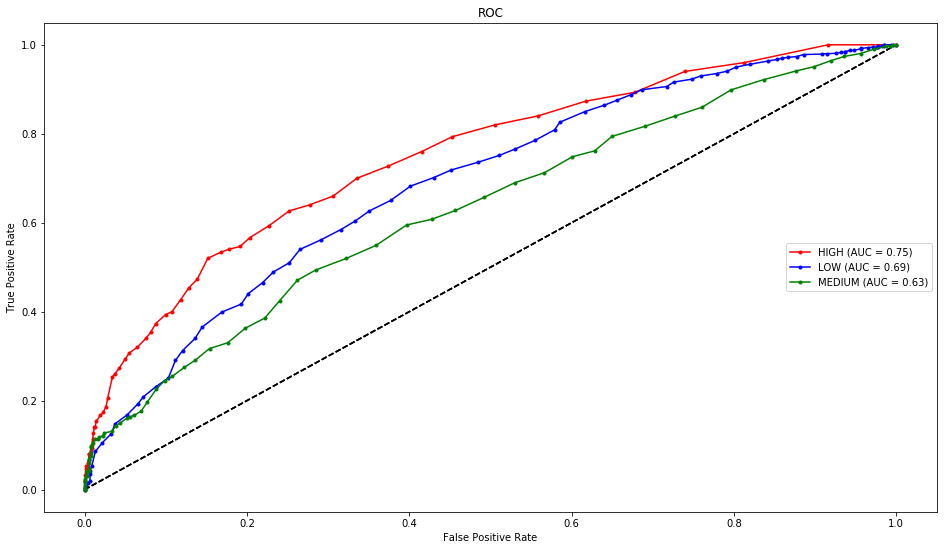

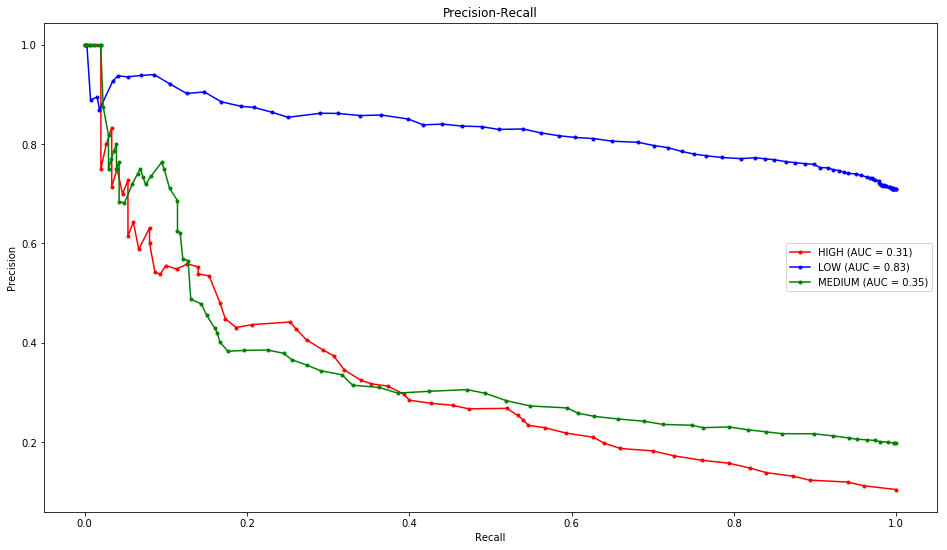

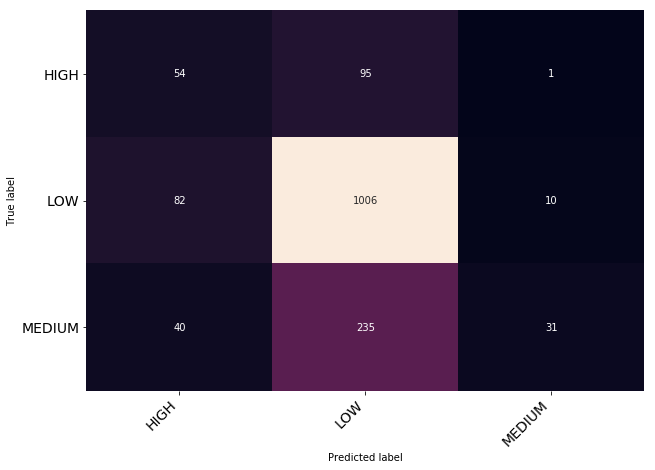

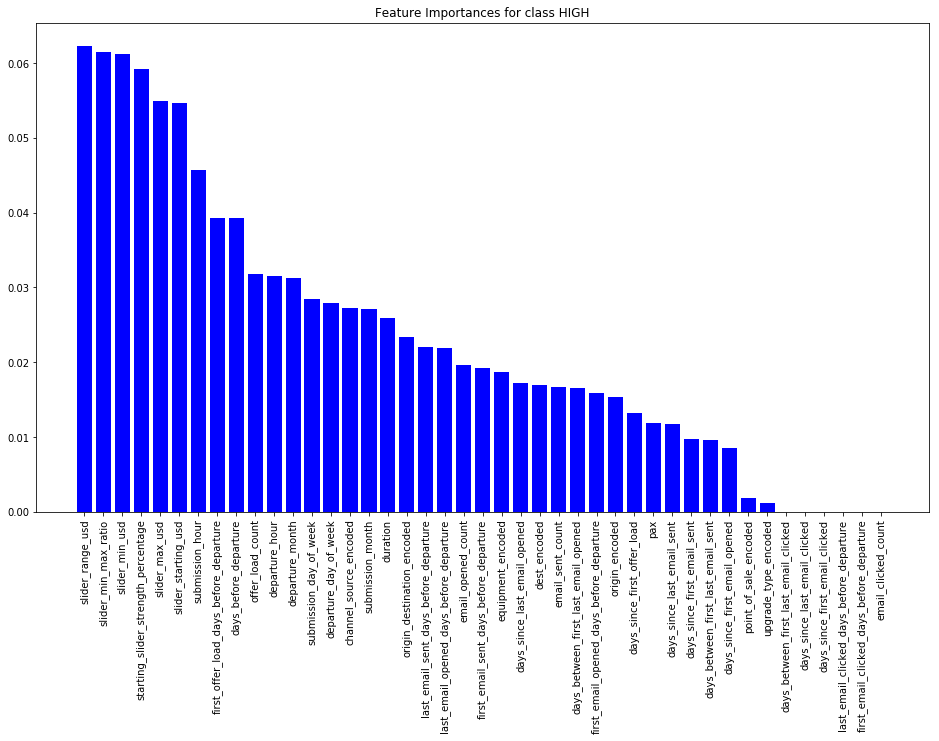

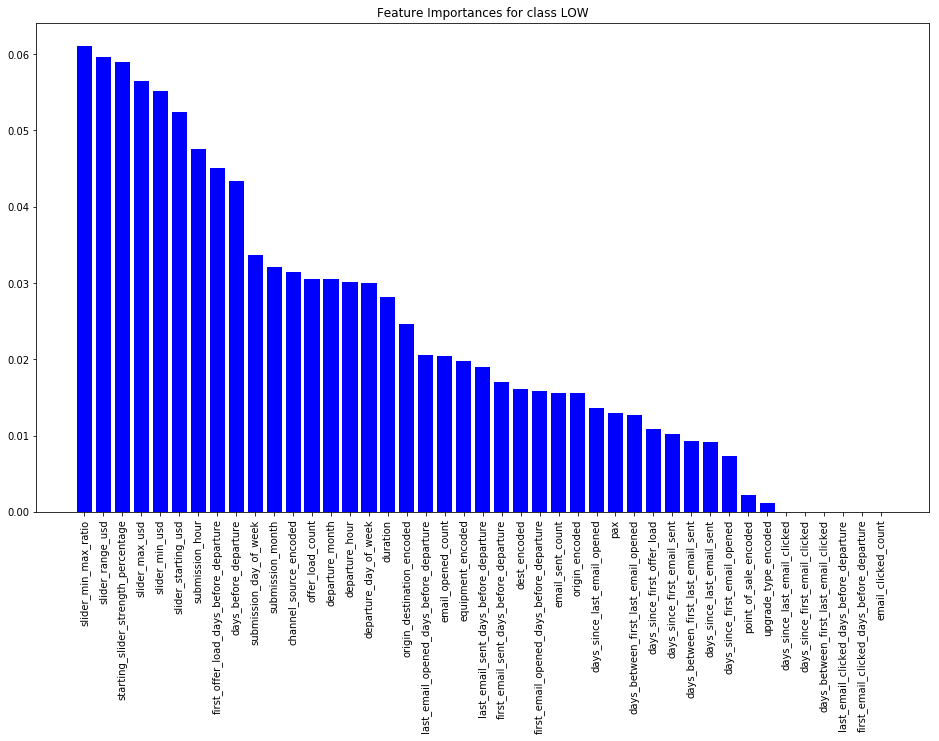

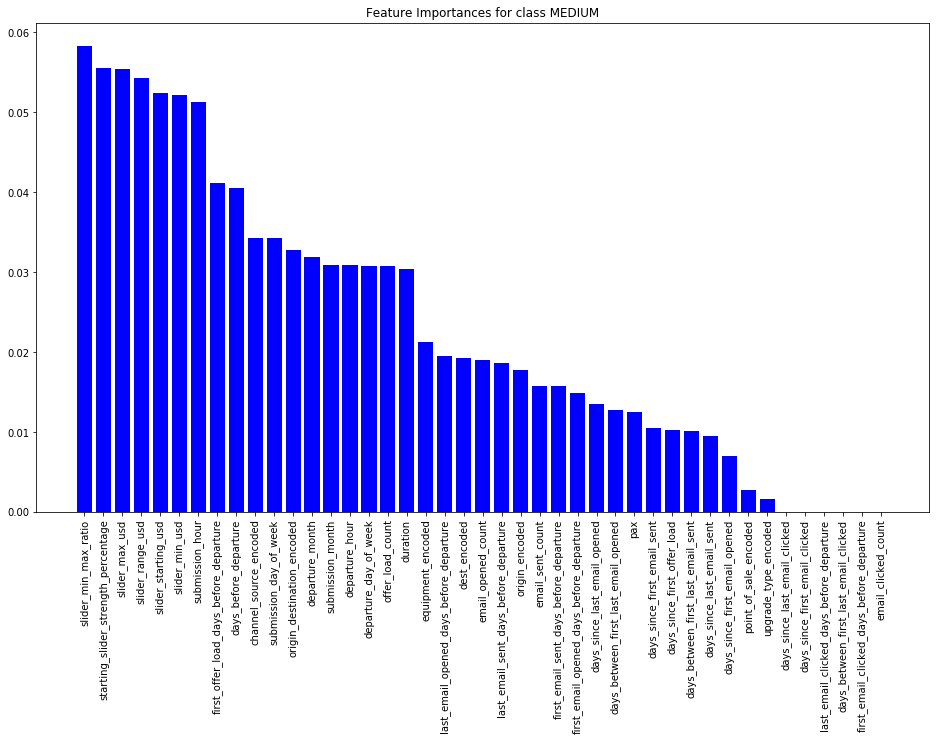

In [94]:
# run with a lot of data
train_and_evaluate(df,plot_learning_curves=False)

In [ ]:
train_and_evaluate(df,plot_learning_curves=False,split_on_time=True )